# M1
Karl Jacobsen

## Introduction

## Franke-function
We start by importing the module where the classes and functions are stored. 

In [ ]:
from classesRegression import *

Now we create some data using the Franke-function and take a look at the function shape.

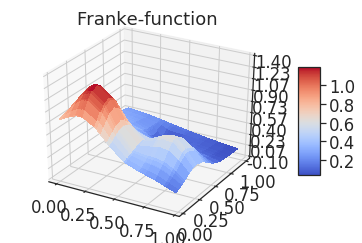

In [2]:
observations = 30
xPlot, yPlot, zPlot = createFrankeData(plot=True, observations=observations)

We see that a higher order polynomial will be necessary to have a chance of approximating the Franke-function. The Franke-function is highly non-linear.

### OLS. Parameter uncertainty
We will approximate the Franke function with polynomial regression. In order to decide which polynomial order to use, we make comparisons of the results using different polynomial degrees in the training. The comparisons will be made on error measures such as the Mean Squared Error (MSE) and the R2 score. 

In [3]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

tst1 = Problem(xPlot, yPlot, zPlot, trueFunction=FrankeFunction)
maxDegree=5
tst1.lsKfold(maxDegree=maxDegree)
#tst1.varBeta()


### OLS. Error analysis
As promised before the discussion about parameter variance, we will now study MSE and R2. In the study of modell performance, it is crusial to distinguiss between performance measured on a test set and on the training data itself. By comparing the performance of different polynomial degrees by MSE and R2 from traning data, one will probaly not find the best model. The error measures for the training data typically always decreases with the complexity of the model, leading to the false conclusion that the more complex the model, the better. The problem with a highly complex model, is that the predictions from this model will be highly variable with the input. A model very senesitive to the input data, does not generalize well, meaning that the model does not work well for other data than the data it was created with. This problem is called overfitting. <br>

Overfitting can be measured by measruing the preiction error from a given model on data that was not used in estimating the model. We split the data in training and test sets. Techniques for splitting the data in test and training sets are called resampling techniques. <br>

We will apply two different resampling techniques: K-fold and Bootstrapping. With the F-fold method, the data is split in K number of folds. One of the folds are chosen as the testing set, while the remaining folds are used for traning the model. This is repeated K number of times, each time with a different fold as the test set. We get K models, and we compute the error measures for all of them. Finally we averge the error measures over the models, getting scalars for the error measures for the given polynoial degree. <br>

With Bootstrapping, the other resampling technique, the data set is split into test and tranining set by random drawing. The tranining observations are drawn from the full dataset, with replacement. The number of observations in the training set equals the number of observations in the full data set. The replacement and the size of the training set implies that there almost always will be duplicats in the training set. The observations not contained in the training set makes up the test set. Typcally the split is 65/35 for training/test observations.<br>

The following code produce figures for $MSE_{training}$,  $MSE_{testing},\; R2_{training}$ and $R2_{testing}$ as functions of the polynomial degree.

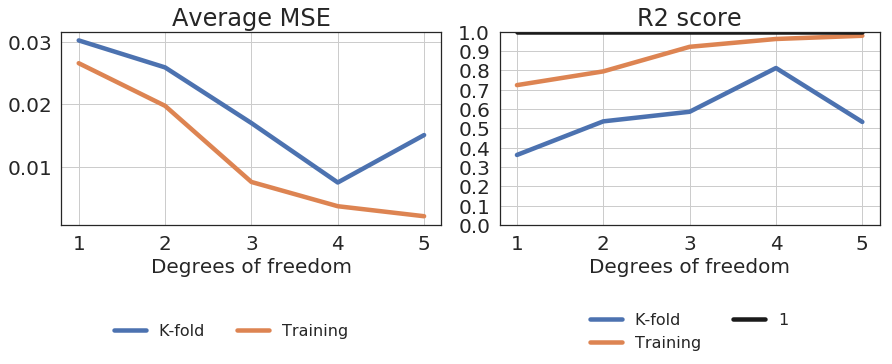

In [5]:
lastDegree = maxDegree
tst1.mseFigures(lastDegree=lastDegree)

The figure to the left above shows that for the training set the MSE always decreases with the degrees of freedom. We also see that the K-fold method gives higher MSE compared to the training set. Contrary to the training MSE, the K-fold MSE reaches a point where more complexity with regards to polynomial degree does not make the fit better. The best polynomial degree seems to be everything below 5, since the MSE of the K-fold method is pretty constant in this range. <br>

Another way to study the fit, is by computation of the so-called R2-score. An R2-score equalt to one is a perfect fit, and the R2 is normally between zero and one. The figure to the right above shows the same story as the figure to the left. Furthermore, we see that the quality of the fit for the training set becomes extremely good, since the R2-score approaches one when the degrres of freedom increse. The R2 score for the K-fold method actually becomes negative, which is a rather seldom phenomenon, suggesting that the fit is no longer good. <br>

The reason for the increase in MSE with complexity has to do with increased variance due with model complexity. When the model is complex, a small change in the data will affect the estimation results to a high degree. Hence the MSE will vary a lot between the different folds in the K-fold validations when the model is complex. The following code produces a figure, where we have decoposed the MSE of all MSE's at given degrees of freedom into contributions from the squared bias and the variance, showing the contributing factors behind the change in MSE. 

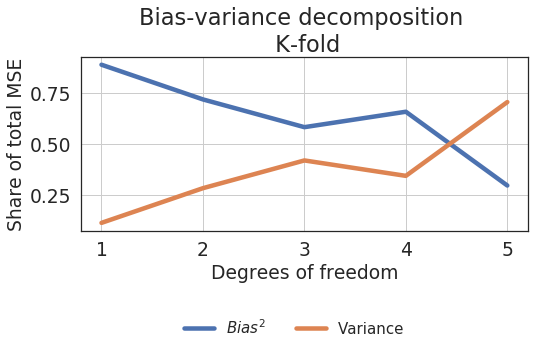

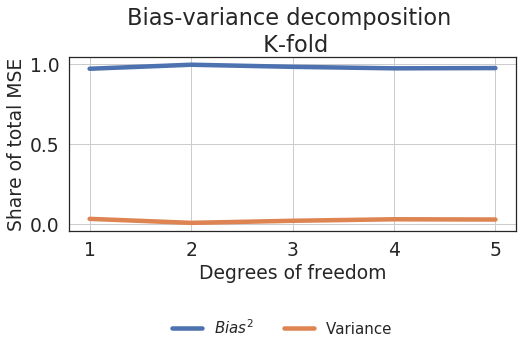

In [6]:
lastDegree = maxDegree
tst1.biasVariancePlot(lastDegree=lastDegree)

The figure above shows that the bias contribution to the K-folds MSE decreeses, while the variance constribution increases, with the degrees of freedom. This observation, reduced bias and increased variance with complexity, is classical for overfitting. 

### Ridge and Lasso regression
Ridge and Lasso regression differs from OLS by including a punishment term in the cost-function. When model complexity is becoming large in the OLS-problem, giving overfitting, the design matrix becomes singular. By adding the penalty term the design matrix becomes invertible and Ridge and Lasso regression gives solutions. <br>

For Ridge regression the penalty term equals the squared absolute value of coefficients times a chosen parameter, while for Lasso the penalty term equals the absolute value of coefficients times a chosen parameter. In contrast to Ridge regression, Lasso can give parameter values equal to zero, which is practical when determining relevant predictors. <br>

The following code produces figures for comparing training MSE between three models, the testing MSE between the three models and the bias-variance distribution of the three models. As punishment parameters we have chosen $\lambda =1 $ for Ridge and $\lambda = 0.001$ for Lasso. For OLS and Ridge our own class is applied, while Sci-Kit learn is applied for Lasso.

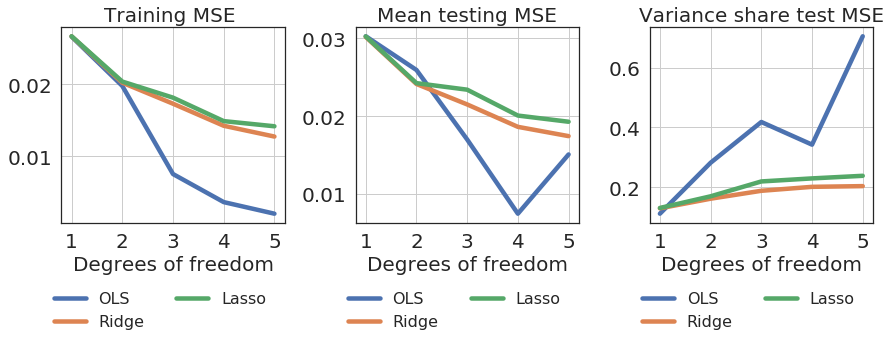

In [7]:
tst1.mseAllModels(franke=True)
tst1.mseAllModelsPlot()

From the figure to the left above we see that the training error is always lowest for the OLS-model. It was expected that the training error was lowest for the OLS model, because OSL minimizes the training error, while the other model minimizes different cost-functions than the training error. <br>

In the middle figure above, we see that the rankings of model performance is turned around when one measures the model performance on test sets. 10-fold cross validation has been used. Now the OLS estimator performs worst. We see that in contrast to OLS, the Ridge and the Lasso model do not get the sudden explosion in test MSE when the degree become five. The punishment terms makes the Ridge and the Lasso estimators avoid the problem with nearly singular matrices when the model complexity gets high. <br>

The figure to the right, which shows the variance share of total MSE, illustrats the effect of the punishment terms in the Ridge and the Lasso estimators. The punishment term reduces the test MSE by reducing the variance. When the punishment term is large, there is a large punishment for large parameter values. Hence the parameter values are pressed down a lot when the punishment term is large. With lower parameter values, the models react less when applied to new test sets. Hence the variance contribution to MSE is reduced with the introduction of penalty terms.<br>

The middle figure above suggests that the complexity can increase even more when applying the Ridge or the Lasse estimators. Without looking at the coefficient values, it can be misleading only looking at the degrees of freedom number to determine the optimal degrees of freedom. With Ridge and Lasso, several parameters can be close to zero, so that the effective degrees of freedom is less than what was sent into the model. This is a strength with the Ridge and Lasso estimator's. We can use high degrees of freedom, and the models themselves decides which of the parameters it will actually use, so we migth avoid doing this degrees of freedom analysis that we have done til now. <br>

A natural next question is to ask about the optimal size of the punishment parameters. We will now study this question by solving the models for different values of punishment parameters. 

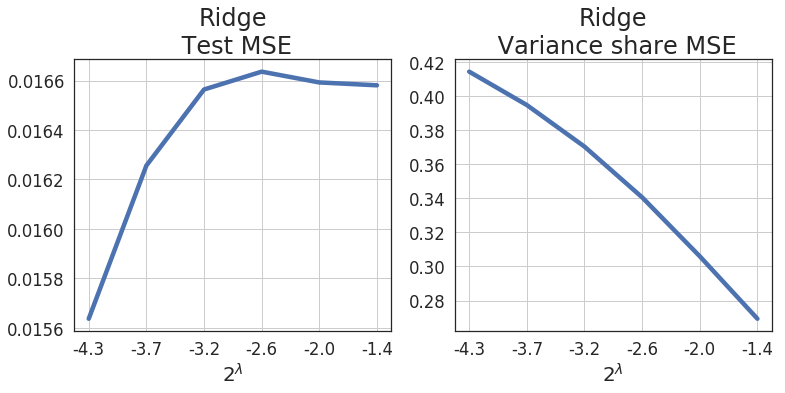

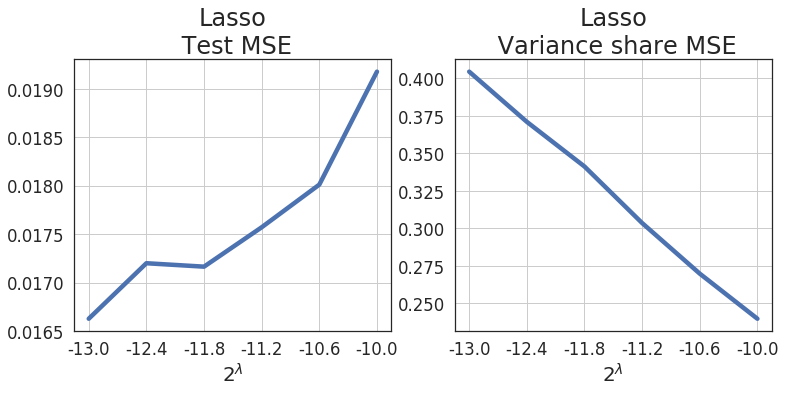

In [8]:
tst1.punishmenParameterAnalysis()

The top row in the figures above shows the test MSE and variance share of MSE for the Ridge estimator for different punishment parameters. The second row in the above plot shows the same as the first row, but now for the Lasso estimator. <br>

For Ridge we see that an optimum $\lambda_{Ridge}^*$ is reached for $\lambda = 0.2$. From the rigth figure in the first row we see that the variance share of MSE is reduced when the punishment parameter increases. The increase in the variance share with punishment parameter size was expected. The model becomes more simple, and hence less sensitive to changes in test set when the punishment parameter is increased. The parameter values are lower when the punishment parameter is high. <br>

From the bottom row in the figure above, which shows the test MSE and the variance share of MSE for Lasso, shows that the story is the same for Lasse it was for Ridge. There is an optimum punishment parameter size, $\lambda_{Lasso}^* = 0.00025$, that minimizes test MSE. <br>

By comparing the first column of plots in the figure above, we see that the Ridge regression seems to outperform Lasso when it comes to minimizing the test MSE. Since both the Ridge and the Lasso estimators for optimal punishment parameters  outperforms OSL, the overall ranking of the models from best to worst are: Ridge, Lasso, OLS. <br>

Now lets take a look at how the predictions with the optimal parameters look like. First we look at the full data set when we apply the Ridge estimator with optimal $\lambda = 0.2$.

In [10]:
#tst1.preditionAndPlot(model='ridge', degree=5, lambdaValue=0.2, maxIterations=100000)
testPercentage = 20
tst1.preditionAndPlot(xPlotTest, yPlotTest, zPlotTest, model='ridge', degree=5, lambdaValue=0.2, maxIterations=100000, \
                          plotResiduals=False, testPercentage=testPercentage)

NameError: name 'xPlotTest' is not defined

We see that the approximation is considerably smoother than the true data. The reason for this is the smoothing due to the punishment parameter. The punishment parameter was chosen based on test MSE, so the approximation will most likely do better than OLS when applied to testing sets. <br>

Next we look at the results for the Lasso estimator when applied on the full set with the optimal punishment parameter $\lambda = 0.00025$.

In [ ]:
tst1.preditionAndPlot(model='lasso', degree=5, lambdaValue=0.00025, maxIterations=100000)

We see that the results for Lasso looks very similar to the results from Ridge. Both estimators give smooth predictions. The similarity of the predictions of Lasso and Ridge is not suprising in this case. From the figures where we decided the optimal punishment parameters, we saw that the MSE's of Lasso and Ridge were very similar for their respective optimal punishment parameter values.

### The effects of noise on MSE
Til now we have used the pure Franke-function as input to our data without any extra noise. If the Franke-function had been in the Span of our basis functions, we would have gotten a perfect fit with zero error. However, our basis functions do not span the Franke-function. Hence we do not get a perfect fit. There will always be an error. <br>

In order to see what the effect of noise is on the estimators, we now add more noise, of the NIID type, to the data. In the titles the term "noise" equals the factor $\eta$ in $y = f(x) + \eta \varepsilon,\;\varepsilon \sim \mathcal{N}(0,1)$. The following code produces the following figures.

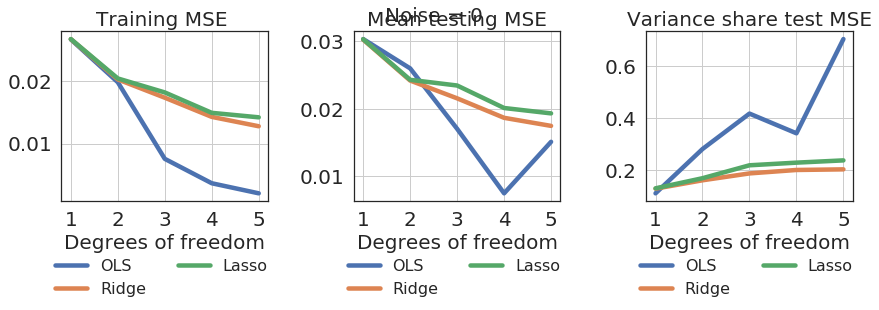

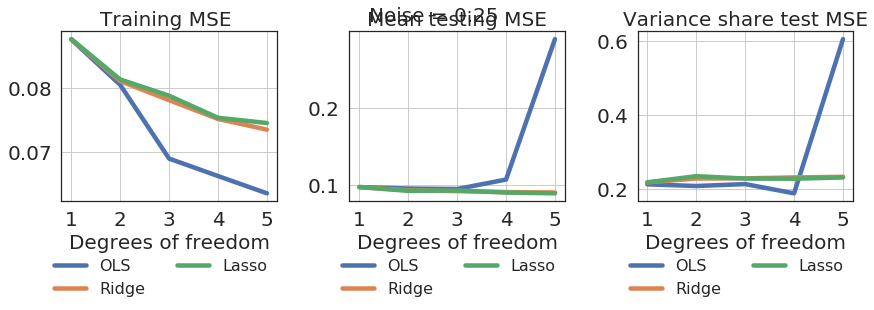

In [11]:
noises = [0, 0.25]
for noise in noises:
    tst1.mseAllModels(noise, franke=True)#, plotResiduals=False, residualsDegree=5)
    tst1.mseAllModelsPlot()

In the figure above, the top row shows MSE measures in the absence of noise, while the bottom row shows the same in presence of noise. <br>

By comparing the first and second row of the first column in the figure above, we see that adding noise increaes the training MSE for all models. Furthermore the relationship between the different models training MSE does not seem to change with noise. <br>

From the middle column we see that adding noise increases the testing MSE of the OLS-model significanlty, while the testing MSE of the other models is much less affected. <br>

From the third column in the figure above we see that the variance share of test MSE is little affected by noise for the OLS-model and the Lasso-model. The variance share of the Ridge model, on the other hand, is affected by the noise. When there is no extra noise, the Ridge model has the lowest variance share of test MSE. In the presence of extra noise, the variance share of the Ridge model increaes significantly with model complexity and becomes larger than for the Lasso model. This reflects the effect of Lasso being able to set parameters to zero, while this is not fully possible with Ridge. Hence the Ridge model can be more sensitive to noise than the Lasso model.


###  Parameter uncertainty and the effects of noise
Now we'll take a look at how the variance of the estimated parameters depends on the polynomial degree. If the random errors are normally distributed, there is a formula for estimation of the variance of the parameters. Applying this formula we will compare the standard deviation of the three first parameters in polynomial fits from degree one to degree five. The three first parameters were chosen, since these parameters appear inn all the polynomial fits. Furthermore, we will report the standard deviation divided by the absolute value of the corresponding parameter estimate. Comparing the ratios of standard deviation to parameter values allows us to say something more about the condidence intercal of the parameter. <br>

We will study the parameter variances for the OLS-estimation on the full set. The next figure shows the standard deviation to parameter value for the three first parameters, for noise parameters $\eta = 0$ and $\eta = 0.5$ in  $y = f(x) + \eta \varepsilon,\;\varepsilon \sim \mathcal{N}(0,1)$.

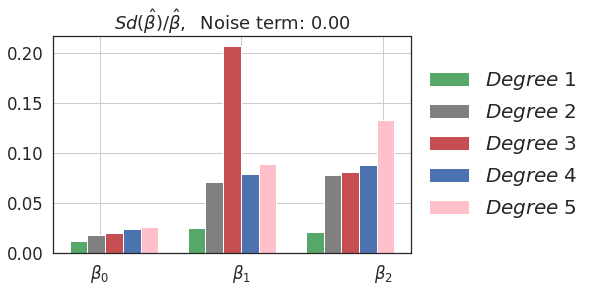

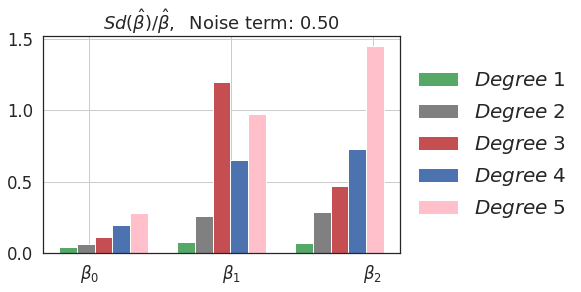

In [12]:
noises = [0.0, .5]
tst1.varBetaFigures(noises=noises)

First we note from the figures that the relation between parameter uncertainty and model complexity relates to the previous findings that uncertainty increases with model complexity. From the figure above we see that the uncertainty in the paremeter estimates increases with the model complexity. In other words, the confidence intervals widens with the polynomial degree. For normal distributed variables, a 95 per cent confidence interval is approximately $[\hat{\beta} - 2 Sd(\hat{\beta}), \hat{\beta} + 2 Sd(\hat{\beta})]$. The values in the figures above suggest that the limits of some of the confidence interval's are larger than the parameters themselves, suggesting that the parameter estimates are very uncertain. <br> 

We also see that larger variance in the stochastic error term has a huge impact on the parameter variances. The values in the second figure above is much larger compared to the corresponding values in the first figure. <br>

The formula applied for the parameter variances describe noise due to stochastic errors. In our case, where the true model is not spanned by our basis functions, the MSE includes this error from use of wrong basis functions. An alternative interpretation is that the extra error, the error in addition to the Gaussian noise, is due to measurement errors. If the total error, the sum of the Gaussian error and the extra error, is normally distributed, the equation used for the parameter variances applied in the figures above should still hold. <br>

In order to study whether the normality assumtion about the errors for the parameter variance formula holds, we now study the distribution of the residuals in our fit with the OLS-model.

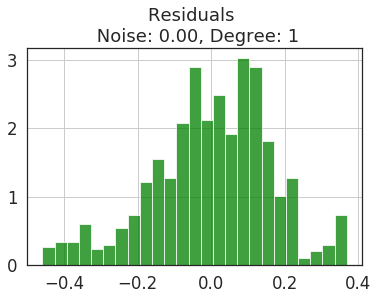

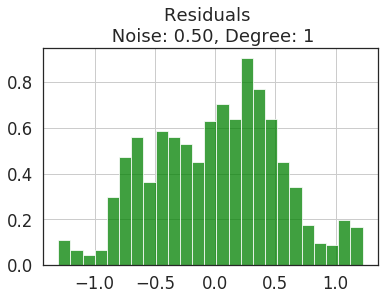

In [14]:
noises=[0, 0.5] 
nBins=25
tst1.createResidualHistograms(noises=noises, nBins=nBins)

From the first figure above we see that the original residual distribution does not seem to be very Gaussian. Hence the interpretation of the extra error, the error when there is no Gaussian noise added, as being random normally distributed disturbances in the data does not to be very good. <br>

The second plot in above shows that adding Gaussian noise does not make the residuals look Gaussian eighter. The residuals get more spread out in the presence of Gaussian noise. The stregnth of the Gaussion noise is not large enough compared to the "extra error" to make the residuals Gaussian. <br>

We condlude that we do not have Gaussian error terms. However, Hastie et al. (2009) p. 49 states that the condidence intervals of the parameters are not much changed when the assumption of Gaussian noise is relaxed. Hence we still have faith in the calculated parameter variances above. 

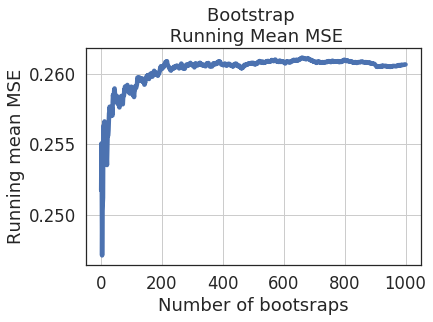

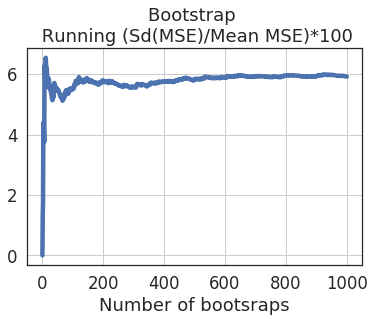

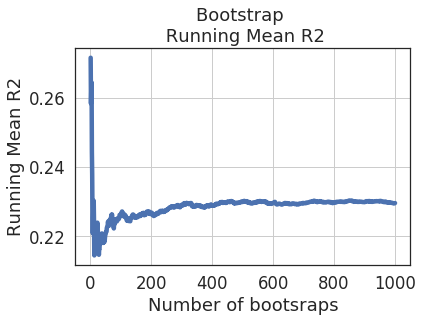

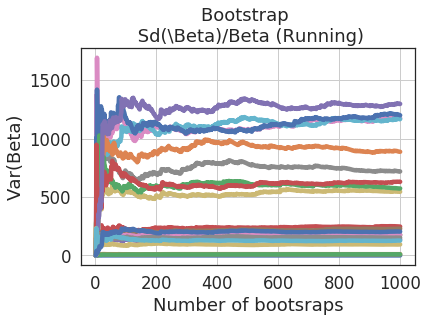

In [15]:
bootstraps  = 1000
tst1.bootstrapParameterVariance(bootstraps=bootstraps, plot=True)

# Terrain data
The analysis above on the Franke function generated data will now be repeated on real digital terrain data. We start by extracting a part of the Norway map.

In [1]:
from classesRegression import *

/home/k/anaconda3/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/k/anaconda3/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/k/anaconda3/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/k/anaconda3/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))


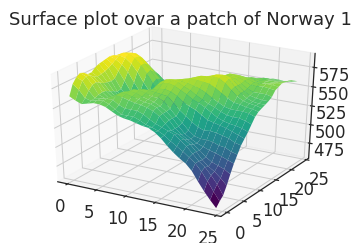

In [2]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


# Real data
from scipy.misc import imread
#from imagio import imread
import imageio
def surface_plot(surface,title):
    M,N = surface.shape

    ax_rows = np.arange(M)
    ax_cols = np.arange(N)

    [X,Y] = np.meshgrid(ax_cols, ax_rows)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y,surface,cmap=cm.viridis,linewidth=0)
    plt.title(title)
    
terrain1 = imageio.imread('SRTM_data_Norway_1.tif')
#surface_plot(terrain1,'Surface plot over Norway 1')
# Extract a smaller patch of the terrain
distance = 25
row_start = 2000
row_end = row_start + distance 
col_start = 1250
col_end = col_start + distance
terrain1_patch = terrain1[row_start:row_end, col_start:col_end]
surface_plot(terrain1_patch,'Surface plot ovar a patch of Norway 1')

### Parameter uncertainty

We will now make estimations of the data in the above figure with OLS and study the parameter variances as functions of degrees of freedom. As discussed in the case of the Franke function generated data, the formula for the parameter variances assumes NIID noise terms. We do not know whether our noise is NIID. We will first compute the parameter variances with the formula assuming normal distributed error terms, and then we will astudy the residuals. As for the Franke-function generated data, the parameter variances are calulated from the full data set.

len(x) inside Design  625
len(self.z) 625
Inside calError self.r2, self.mse  0.09041861341752155 487.5469724553846
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  234
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  231
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  231
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  234
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  224
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  240
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  230
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  225
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  235
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  234
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  233
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  227
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  221
l

len(x) inside Design  625
len(self.z) 625
len(x) inside Design  238
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  220
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  225
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  222
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  222
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  227
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  229
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  229
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  235
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  233
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  238
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  228
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  213
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  230
len(x) inside Design  625
len(self.z) 625
len(x)

len(x) inside Design  625
len(self.z) 625
len(x) inside Design  236
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  221
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  230
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  232
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  241
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  222
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  228
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  225
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  238
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  222
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  229
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  236
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  218
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  229
len(x) inside Design  625
len(self.z) 625
len(x)

len(x) inside Design  625
len(self.z) 625
len(x) inside Design  224
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  240
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  240
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  230
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  226
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  233
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  225
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  230
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  219
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  241
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  233
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  217
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  228
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  236
len(x) inside Design  625
len(self.z) 625
len(x)

len(x) inside Design  625
len(self.z) 625
len(x) inside Design  227
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  234
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  241
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  228
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  238
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  234
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  234
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  244
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  226
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  228
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  230
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  230
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  239
len(x) inside Design  625
len(self.z) 625
len(x) inside Design  235
len(x) inside Design  625
len(self.z) 625
len(x)

/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  558
len(self.z) 558
len(x) inside Design  67
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design

/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

len(x) inside Design  625
len(self.z) 625
Inside calError self.r2, self.mse  0.8848924812547234 61.69906629462696
len(x) inside Design  625
len(self.z) 625
Inside calError self.r2, self.mse  0.7722485875885422 122.07759880712463


/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  558
len(self.z) 558
len(x) inside Design  67
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design

/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

len(x) inside Design  625
len(self.z) 625
Inside calError self.r2, self.mse  0.9069882569743016 49.85545481021721
len(x) inside Design  625
len(self.z) 625
Inside calError self.r2, self.mse  0.7611491116465575 128.02705640507352
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  558
len(self.z) 558
len(x) inside Design  67
len(x) inside Design  563
len(self.z) 563
len(x) inside Design  62
len(x) inside Design  563
len(self

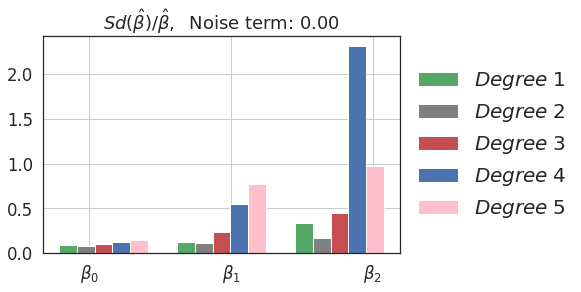

In [3]:
num_rows, num_cols = terrain1_patch.shape
rows = np.arange(num_rows)
cols = np.arange(num_cols)
[xPlot,yPlot] = np.meshgrid(cols,rows)
zPlot = terrain1_patch


terrain = Problem(xPlot, yPlot, zPlot, trueFunction=FrankeFunction)
terrain.lsKfold()

terrain.varBetaFigures()

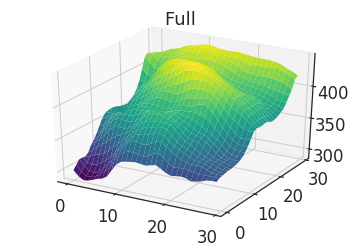

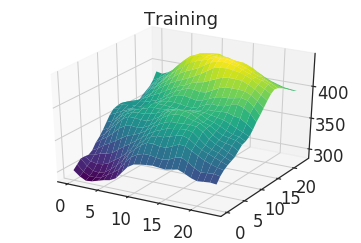

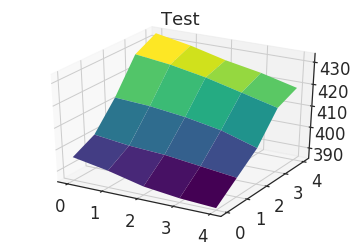

In [18]:
# Test set, R2


# Training data


# Full data
distance = 25
testPercentage = 20
row_start = 2000#int(round(2000*(1+testPercentage/100.)))
row_end = int(round(row_start + distance*(1+testPercentage/100.)))
col_start = 1000#1250
col_end = int(round(col_start + distance*(1+testPercentage/100.)))
terrain1_patchTest = terrain1[row_start:row_end, col_start:col_end]
surface_plot(terrain1_patchTest,'Full')

IndexSplit = int(round(num_rows*(1-testPercentage/100.)))

# Training
row_startTrain = row_start
row_endTrain = row_startTrain + IndexSplit
col_startTrain = col_start
col_endTrain = col_startTrain + IndexSplit
terrainTrain_patch = terrain1[row_startTrain:row_endTrain,\
                              col_startTrain:col_endTrain]
surface_plot(terrainPatchTrain,'Training')

# Test
row_startTest = row_endTrain+1
row_endTest = row_end
col_startTest = col_endTrain+1
col_endTest = col_end
terrainPatchTest = terrain1[row_startTest:row_endTest,\
                              col_startTest:col_endTest]
surface_plot(terrainPatchTest,'Test')

In [19]:
num_rows, num_cols = terrain1_patchTest.shape
rows = np.arange(num_rows)#+3*distance
cols = np.arange(num_cols)
[xPlotTest,yPlotTest] = np.meshgrid(cols,rows)
zPlotTest = terrain1_patchTest
print('\n np.shape(zPlotTest)\n ', np.shape(zPlotTest))
plot = False

terrain2 = Problem(xPlotTest, yPlotTest, zPlotTest, trueFunction=FrankeFunction)
terrain2.preditionAndPlot(xPlotTest, yPlotTest, zPlotTest, model='ridge', degree=5, lambdaValue=0.2, maxIterations=100000, \
                          plotResiduals=False, testPercentage=testPercentage,\
                         plot=plot)



 np.shape(zPlotTest)
  (30, 30)
180 720 180 720 180 (720,)
len(x) inside Design  720
len(self.z) 720
len(x) inside Design  180
Inside calError self.r2, self.mse  0.2214613922558395 636.0123137514571
In calcPlot mse, r2 636.0123137514571 0.2214613922558395


In [9]:
IndexSplit = int(round(num_rows*(1-testPercentage/100.)))
IndexSplit

24

In [20]:
terrain2.mse
terrain2.r2

0.2214613922558395

The figure above shows that the parameter variances relates to the model complexity in the same was for the Franke-function. The parameter variances generally increas with model complexity. <br>

A notible difference is the size of the parameters standard errors. The standard errors of the parameters relative to their estimation value is considerably larger for the terrain data. Values above one in the above graph implies that the 95 % condidence interval, in the case of a normal distributed errors, include both signs for one and the same coefficient. Hence these are very uncertain estimates! <br>

As we did for the Franke-function generated data, we will have a look at the residuals in order to study the error distribution. 

/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

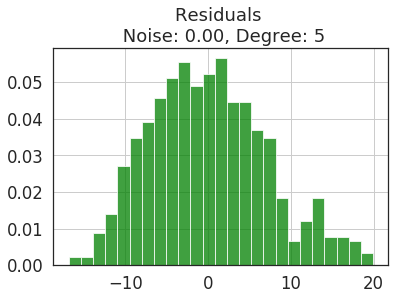

In [20]:
nBins=25
residualsDegree = 5
terrain.createResidualHistograms(nBins=nBins, residualsDegree=residualsDegree)

From the above figure we see that the residuals look more Gaussian than in the Franke-function generated data. Hence the parameter variance estiamtes, and their confidence intervals, should be better in the case with real terrain data.

### Quality of fit
Next compare the training and test MSE and R2 for different degrees of freedom.

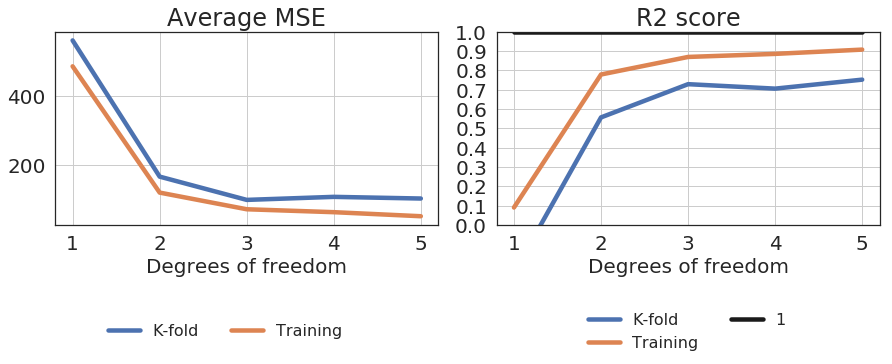

In [21]:
terrain.mseFigures()

As for the Franke-function, the training MSE is always lower than the test MSE and the training R2 is always higher than the test R2. <br>

A noticable difference from the Franke-function is the value of the average MSE. The average MSE is much higher for the real data. Looking at the image of the data this is not surprising. The real data is much more noisy and complex than the data generated by the Franke-function without noise. Furthermore the results from the study of extra noise in the Franke-function also supports the higher MSE in the real data scenario. Extra noise in the Franke-function gave larger MSE's.<br>

We also note that the optimal model complexity might be higher in the real data case compared to the Franke-function generated data case. The test MSE, represented by the label "K-fold" in the above two figures, has maybe not reached a minimum yet at five degrees of freedom. <br>

Next we study the bias-variance decomposition of the MSEs.

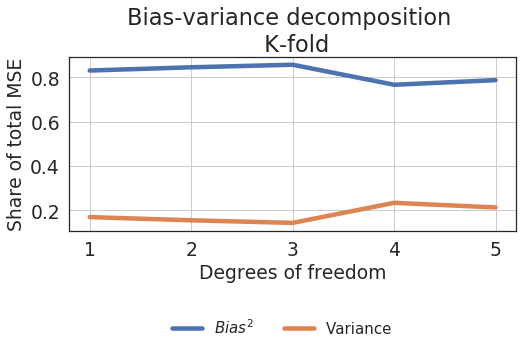

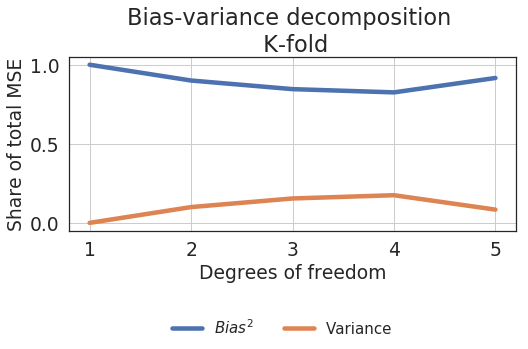

In [22]:
terrain.biasVariancePlot()

In contrast to the Franke-function scenario, the addtion of higher order predictors does not increase the variance share of the MSEs particularly in the terrain data scenario. Together with the fact that the test MSE has not started to increase at degree 5 this suggests that more complexity might benefit the fit.<br>

Next we compare the MSEs for the three different models, OLS, Ridge and Lasso.

/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

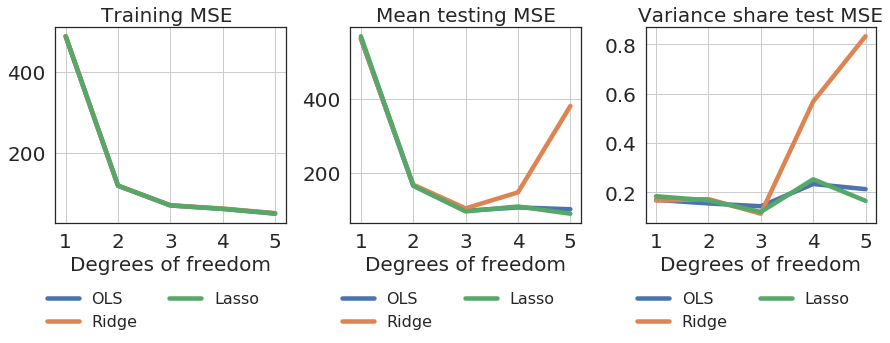

In [23]:
maxIterations=100000
ridgeLambda = 0.1 
lassoLambda = .01
terrain.mseAllModels(maxIterations=maxIterations, ridgeLambda = ridgeLambda, \
                  lassoLambda = lassoLambda)
terrain.mseAllModelsPlot()

From the left figure we see that for training, everything is as before, with OLS being lowest. The MSE values are much higher than in the Franke-scenario. <br>

The testing MSE, shown in the middle figure above, is different from the Franke-scenario. Now the Ridge regression gives the largest testing MSE. This may indicate that there should not be any punishment of the parameters. <br>

The figure above to the right shows that the Ridge regression has the largest variance share in the MSEs. This is strange. <br>

Next we loclize and approximation of the optimal punishment parameters.

In [ ]:
maxIterations=1000000
terrain.punishmenParameterAnalysis(startLambdaRidge = 0.001, startLambdaLasso =  1.0,\
                                numberOfPoints = 3, maxIterations=maxIterations)

AttributeError: 'numpy.ndarray' object has no attribute 'rehsape'

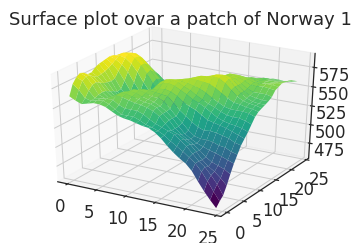

In [24]:
# Test set: Equally sized patch next to tranining/validation patch

# Training data
surface_plot(terrain1_patch,'Surface plot ovar a patch of Norway 1')

# Test data
distance = 25
row_start = 2000+3*distance
row_end = row_start + distance 
col_start = 1250
col_end = col_start + distance
terrain1_patchTest = terrain1[row_start:row_end, col_start:col_end]
num_rows, num_cols = terrain1_patchTest.shape
rows = np.arange(num_rows)
cols = np.arange(num_cols)
[xPlotTest,yPlotTest] = np.meshgrid(cols,rows)
zPlotTest = terrain1_patchTest

terrain.preditionAndPlot(xPlotTest, yPlotTest, zPlotTest, model='ridge', degree=5, lambdaValue=0.2, maxIterations=100000, \
                          plotResiduals=False)
#print(tst1.residuals)



As for the Franke function, the RIdge regression gives a smoother surface than the data. Now lets do the Lasso regression.

In [ ]:
terrain1.preditionAndPlot(model='lasso', degree=5, lambdaValue=0.001, maxIterations=100000)

# Sci-kit learn comparisons
This section includes comparison of our own methods with corresponding Sci-Kit learn methods.

### Test of OLS and Ridge
Before we turn to the analysis using the linear regression model, we first check whether the class above produces the same results as Sci-Kit learn. The following code, which also contains its results, show that the class above produces the same parameter estimates, the same predictions and the same errors as Ridge for both the OLS-estimator and the Ridge-estimator.

In [ ]:
# Scitkit learn. Testing whether our code gives the same mse and R2 on the training set as scl.
from sklearn.linear_model import LinearRegression

x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)

xPlot, yPlot = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

zPlot = FrankeFunction(xPlot, yPlot)

x = np.reshape(xPlot, -1, 1)
y = np.reshape(yPlot, -1, 1)
z = np.reshape(zPlot, -1, 1)


XHat = np.c_[x, y]
degree = 5
poly = PolynomialFeatures(degree)
XHat = poly.fit_transform(XHat)

regressionTypes = 'LS', 'Ridge'
for regressionType in regressionTypes:
    print('\n ##################Regression type: %s' %regressionType, '################## \n')
    if regressionType == 'LS':
        lambdaValue = None
        linreg = LinearRegression()
        linreg.fit(XHat, z)
        predictScitKit = linreg.predict(XHat)

    else:
        lambdaValue = 2
        linreg=linear_model.Ridge(alpha=lambdaValue, fit_intercept = False) #False
        #XHatSCL = np.c_[np.ones_like(x), x, y]
        #XHatSCL = np.c_[x, y]
        #XHatSCL = XHat
        #linreg.fit(XHatSCL, z)
        #predictScitKit = linreg.predict(XHatSCL)
    print('################### Sci-kit learn############################')
    
    linreg.fit(XHat, z)
    predictScitKit = linreg.predict(XHat)


    print('Intercept: ', linreg.intercept_)
    print('Coefficients: ', linreg.coef_)
    print("Mean squared error: %.4f" % mean_squared_error(z, predictScitKit))
    print('R2 score: %.4f' % r2_score(z, predictScitKit))

    print('\n################### My class############################')

    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction, lambdaValue=lambdaValue)
    ls.createDesignMatrix()
    ls.estimate()
    print('betaHat my class: ', ls.betaHat)
    ls.predict()
    ls.calculateErrorScores()
    print('Predictions: zPredict/predictScitKit \n', ls.zPredict/predictScitKit)


    '''
    ##############################PLOTS###################################
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xPlot, yPlot, zPlot, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('Frankel')
    plt.show()

    predictScitKitPlot = np.reshape(predictScitKit, np.shape(yPlot)).T
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xPlot, yPlot, predictScitKitPlot/zPlot, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    #ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('Sci-kit/Franke')
    plt.show()

    predictMyClassPlot = np.reshape(ls.zPredict, np.shape(yPlot)).T
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xPlot, yPlot, predictMyClassPlot/zPlot, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    #ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('My class/Franke')
    plt.show()
    '''

### K-fold. Own vs sci-kit

In [ ]:
# Sci-kit learn Cross validation

from sklearn.linear_model import LinearRegression

fontSize = 15

np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

#x = np.linspace(0,1,5)
#y = np.linspace(0,1,5)
xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)
x = np.reshape(xPlot, -1, 1)
y = np.reshape(yPlot, -1, 1)
z = np.reshape(zPlot, -1, 1)


def display_scores(scores):
    #print("Scores:", scores)
    #print("Mean:", scores.mean())
    #print("Standard deviation:", scores.std())
    return  scores.mean(), scores.std()

mses = []
mseKF = []
error = []
maxDegrees = 6
numberOfFolds = 10
linreg = LinearRegression()

for degree in range(1, maxDegrees+1):
    poly = PolynomialFeatures(degree)
    XHat = np.c_[x, y]
    XHat = poly.fit_transform(XHat)
    lin_scores = cross_val_score(linreg, XHat, z,
                             scoring="neg_mean_squared_error", cv=numberOfFolds)
    lin_rmse_scores = -lin_scores
    mse, std = display_scores(lin_rmse_scores)
    mses.append(mse)
    
    lsKF = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    lsKF.kFold(numberOfFolds=numberOfFolds)
    mseKF.append(np.mean(lsKF.mseSciKit))
    error.append(lsKF.totalError)

#print('\n Manually calculated MSE/ MSE sci-kit-function  \n', np.array(error)/np.array(mseKF))
    
degrees = np.arange(1, maxDegrees+1)
fig, ax = plt.subplots()
legends = ['Sci-Kit', 'Own method']#
methods = mses, mseKF#, error
for degree, method, label in zip(range(1, maxDegrees+1), methods, legends):
    ax.plot(degrees, method, label=label)
#fig.legend(legends)


ax.set_title('MSE', fontsize = fontSize*1.5)
ax.set_xlabel('Degrees of freedom', fontsize = fontSize*1.25)
ax.set_xticks(degrees)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
ax.legend(legends, loc='center left', bbox_to_anchor=(-0.2, -0.55), \
           fontsize = fontSize, ncol=2)
ax.tick_params(axis='both', which='major', labelsize=fontSize*1.25)

# References
Hastie, T., Tibshirani, R. and Friedman, J. (2009). The elements of statistical learning. Springer.

# Unused testing stuff
### Bootstrap Bias-variance

In [ ]:
np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)

def frankeNoise(z, noiseSize):
    return z+ noiseSize*np.random.randn(len(z))

noiseSize  = 0.5

zPlot = frankeNoise(zPlot, noiseSize)

maxDegree = 6
degrees = np.arange(1, maxDegree)
bootstraps = 10
bias, variance, noise, totalError = [], [], [], []
for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    #ls.createDesignMatrix()
    #ls.estimate()
    #ls.predict()
    #ls.plot()
    #ls.calculateErrorScores()
    #ls.calculateVarianceBeta()
    ls.errorBootstrap(bootstraps=bootstraps, plot=False)
    bias.append(ls.bias2)
    variance.append(ls.variance)
    noise.append(ls.noise)
    totalError.append(ls.totalError)
print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError, )

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees[:-1], variables[i][:-1], label=legends[i][:-1])
fig.legend(legends)

### K-fold bias-variance

In [ ]:
# Testing K-fold

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)
xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)

maxDegrees = 10
degrees = np.arange(1,maxDegrees+1)
bias, variance, noise, totalError = [], [], [], []
for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    #ls.createDesignMatrix()
    #ls.estimate()
    #ls.predict()
    ls.kFold(numberOfFolds=10)
    ls.mseSciKit
    bias.append(ls.bias2)
    variance.append(ls.variance)
    noise.append(ls.noise)
    totalError.append(ls.totalError)    
display_scores(ls.mseSciKit)

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError, )

### Bootstrap other function

In [ ]:
# Testing other function
def f(x, y):
    #z = 2 * np.sin(x * 1.5)
    z = x**2
    return z

def fWithNoise(z):
    z = z+ 5.*np.random.randn(len(z))
    return z

observationNumber = 20
x = np.linspace(0, 4.5, observationNumber)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

fig, ax  = plt.subplots()
z2 = f(x,y)
ax.plot(x, z2)
ax.plot(x, fWithNoise(z2))


xPlot, yPlot = np.meshgrid(x,y)
zPlot = f(xPlot, yPlot)
zPlot = fWithNoise(zPlot)


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, zPlot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



maxDegrees = 11
degrees = np.arange(1, maxDegrees)
bootstraps = 100
bias, variance, noise, totalError, totalErrorForTesting, totalError2 = [], [], [], [], [], []
for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=f)
    #ls.createDesignMatrix()
    #ls.estimate()
    #ls.fit()
    #ls.predict()
    #ls.plot()
    #ls.calculateErrorScores()
    #ls.calculateVarianceBeta()
    ls.errorBootstrap(bootstraps=bootstraps, plot=False)
    bias.append(ls.bias2)
    variance.append(ls.variance)
    noise.append(ls.noise)
    totalError.append(ls.totalError)
    totalErrorForTesting.append(ls.totalErrorForTesting)
    totalError2.append(ls.error2)
print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError, \
      '\n totalErrorForTesting', totalErrorForTesting, '\n totalError2', totalError2, )

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total', 'noise2']
noiseFromOther = [totalError[i]-(bias[i] + variance[i]) for i in range(len(totalError))]
variables = [bias, variance, noise, totalError, noiseFromOther]

for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)